## Training on Cifar 10 Using MXNet and H2O


https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

In [9]:
%matplotlib inline

import matplotlib
import scipy.io
import matplotlib.pyplot as plt

import cPickle
import numpy as np
from scipy.misc import imsave
from IPython.display import Image, display, HTML

## Step 1: Preprocess the data

In [10]:
!mkdir -p ~/.h2o/datasets/

In [11]:
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O ~/.h2o/datasets/cifar-10-python.tar.gz

--2016-10-21 20:21:14--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [17]:
!tar xvzf ~/.h2o/datasets/cifar-10-python.tar.gz -C ~/.h2o/datasets/

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [24]:
import os.path
with open(os.path.expanduser("~/.h2o/datasets/cifar-10-batches-py/batches.meta")) as fd:
    meta = cPickle.load(fd)
print meta

{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


In [206]:
labels = meta['label_names']
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [31]:
def load_cifar10_image_list(filepath):
    images = []
    labels = []
    with open(filepath, 'rb') as fd:
        d = cPickle.load(fd)
        for image, label, filename in zip(d['data'], d['labels'], d['filenames']):
            x = np.array(image)
            x = np.dstack((x[:1024], x[1024:2048], x[2048:]))
            x = x.reshape(32,32,3)
            filename=os.path.expanduser("~/.h2o/datasets/cifar-10-batches-py/"+filename)
            imsave(filename, x)
            images.append(filename)
            labels.append(label)
    return images, labels

In [32]:
x_train = []
y_train = []

for batch in range(1,6):
    batch_name = os.path.expanduser('~/.h2o/datasets/cifar-10-batches-py/data_batch_%d' % batch)
    x,y = load_cifar10_image_list(batch_name)
    x_train.extend(x)
    y_train.extend(y)

In [181]:
!ls ~/.h2o/datasets/cifar-10-batches-py/ | sed -n '1~5000p' # show every 5000th file

abandoned_ship_s_000004.png
automobile_s_002079.png
bufo_viridis_s_000446.png
chihuahua_s_001646.png
domestic_cat_s_000619.png
ferry_s_000003.png
jetliner_s_001695.png
monoplane_s_000189.png
pekinese_s_001349.png
rangifer_tarandus_s_000158.png
stealth_bomber_s_002241.png
tip_truck_s_000896.png
yosemite_toad_s_000052.png


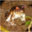

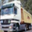

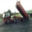

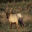

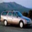

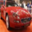

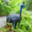

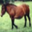

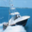

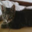

In [183]:
for x in x_train[:10]:
    display(Image(filename=x))

In [198]:
[labels[x] for x in y_train[:10]]

['frog',
 'truck',
 'truck',
 'deer',
 'automobile',
 'automobile',
 'bird',
 'horse',
 'ship',
 'cat']

In [41]:
len(x_train)

50000

In [43]:
batch_test = os.path.expanduser('~/.h2o/datasets/cifar-10-batches-py/test_batch')
x_test, y_test = load_cifar10_image_list(batch_test)

In [74]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,04 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,2 hours and 25 minutes
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.96 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [60]:
!nvidia-smi

Fri Oct 21 20:56:20 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.44                 Driver Version: 367.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980 Ti  Off  | 0000:01:00.0      On |                  N/A |
|  7%   62C    P0    74W / 275W |    792MiB /  6076MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 0000:02:00.0     Off |                  N/A |
| 23%   34C    P8     8W / 250W |      1MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [75]:
train_df = {"x0": x_train, "x1": y_train }

In [76]:
test_df = {"x0" : x_test, "x1": y_test }

In [77]:
train_hf = h2o.H2OFrame(train_df)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [78]:
test_hf = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


Let's turn the class label into a factor

In [79]:
train_hf['x1'] = train_hf['x1'].asfactor()
test_hf['x1'] = test_hf['x1'].asfactor()

In [80]:
train_hf.head(10)

x0,x1
/home/arno/.h2o/datasets/cifar-10-batches-py/leptodactylus_pentadactylus_s_000004.png,6
/home/arno/.h2o/datasets/cifar-10-batches-py/camion_s_000148.png,9
/home/arno/.h2o/datasets/cifar-10-batches-py/tipper_truck_s_001250.png,9
/home/arno/.h2o/datasets/cifar-10-batches-py/american_elk_s_001521.png,4
/home/arno/.h2o/datasets/cifar-10-batches-py/station_wagon_s_000293.png,1
/home/arno/.h2o/datasets/cifar-10-batches-py/coupe_s_001735.png,1
/home/arno/.h2o/datasets/cifar-10-batches-py/cassowary_s_001300.png,2
/home/arno/.h2o/datasets/cifar-10-batches-py/cow_pony_s_001168.png,7
/home/arno/.h2o/datasets/cifar-10-batches-py/sea_boat_s_001584.png,8
/home/arno/.h2o/datasets/cifar-10-batches-py/tabby_s_001355.png,3


In [81]:
from h2o.estimators.deepwater import H2ODeepWaterEstimator

In [82]:
deepwater_model = H2ODeepWaterEstimator(
    epochs=10,                            ## 
    nfolds=3,                             ## 3-fold cross-validation
    learning_rate=2e-3,
    mini_batch_size=64,
#    problem_type='image',                ## autodetected by default
    network='vgg',
#    network_definition_file="mycnn.json" ## provide your own mxnet .json model
    image_shape=[32,32], 
    channels=3,
    gpu=True
)

In [83]:
deepwater_model.train(x=['x0'], y='x1', training_frame=train_hf)

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%


Anytime, especially during training, you can inspect the model in Flow (http://localhost:54321)

![Flow model inspection while the model is training](images/flow-models.png)

Here's the first (of three) cross-validation models:
![Flow model inspection while the model is training](images/cifar10-flow.png)

In [87]:
train_error = deepwater_model.model_performance(train=True).mean_per_class_error()
print "training error:", train_error

training error: 0.16713273474


In [88]:
xval_error = deepwater_model.model_performance(xval=True).mean_per_class_error()
print "cross-validated error:", xval_error

cross-validated error: 0.3618


In [207]:
deepwater_model

Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477112436466_1
Status of Deep Learning Model: vgg, 107.4 MB, predicting x1, 10-class classification, 501,760 training samples, mini-batch size 64



,input_neurons,rate,momentum
,3072,0.0013318,0.99




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.148682043417
RMSE: 0.385593106029
LogLoss: 0.495613927236
Mean Per-Class Error: 0.16713273474
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
748.0,20.0,29.0,16.0,12.0,4.0,6.0,2.0,95.0,43.0,0.2328205,227 / 975
2.0,932.0,0.0,4.0,0.0,0.0,4.0,0.0,33.0,38.0,0.0799605,"81 / 1,013"
26.0,6.0,726.0,53.0,64.0,25.0,73.0,9.0,17.0,8.0,0.2790467,"281 / 1,007"
11.0,5.0,15.0,739.0,25.0,95.0,76.0,4.0,11.0,13.0,0.2565392,255 / 994
10.0,1.0,27.0,36.0,824.0,22.0,55.0,17.0,7.0,9.0,0.1825397,"184 / 1,008"
1.0,3.0,10.0,167.0,37.0,749.0,26.0,8.0,7.0,4.0,0.2598814,"263 / 1,012"
1.0,5.0,11.0,23.0,10.0,4.0,946.0,1.0,1.0,0.0,0.0558882,"56 / 1,002"
11.0,2.0,14.0,45.0,53.0,55.0,6.0,802.0,4.0,26.0,0.2121807,"216 / 1,018"
7.0,11.0,0.0,4.0,1.0,0.0,1.0,0.0,941.0,15.0,0.0397959,39 / 980
4.0,46.0,1.0,8.0,0.0,2.0,1.0,0.0,13.0,957.0,0.0726744,"75 / 1,032"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.8329848
2,0.9298874
3,0.9638482
4,0.9804800
5,0.9900408
6,0.9953191
7,0.9971118
8,0.9985061
9,0.9996016
10,0.9999999



ModelMetricsMultinomial: deepwater
** Reported on cross-validation data. **

MSE: 0.326416394664
RMSE: 0.571328622304
LogLoss: 1.09564677029
Mean Per-Class Error: 0.3618
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
3144.0,196.0,379.0,136.0,221.0,45.0,35.0,119.0,422.0,303.0,0.3712,"1,856 / 5,000"
82.0,3867.0,24.0,48.0,26.0,30.0,67.0,39.0,95.0,722.0,0.2266,"1,133 / 5,000"
273.0,28.0,2535.0,464.0,716.0,373.0,284.0,180.0,70.0,77.0,0.493,"2,465 / 5,000"
64.0,50.0,313.0,2424.0,416.0,847.0,446.0,225.0,77.0,138.0,0.5152,"2,576 / 5,000"
112.0,23.0,399.0,365.0,3154.0,191.0,277.0,386.0,43.0,50.0,0.3692,"1,846 / 5,000"
28.0,26.0,282.0,1190.0,379.0,2466.0,176.0,343.0,23.0,87.0,0.5068,"2,534 / 5,000"
32.0,63.0,228.0,456.0,465.0,130.0,3458.0,48.0,42.0,78.0,0.3084,"1,542 / 5,000"
49.0,26.0,164.0,271.0,648.0,315.0,58.0,3340.0,19.0,110.0,0.332,"1,660 / 5,000"
416.0,245.0,74.0,125.0,71.0,43.0,44.0,36.0,3705.0,241.0,0.259,"1,295 / 5,000"
149.0,457.0,36.0,123.0,39.0,57.0,84.0,122.0,116.0,3817.0,0.2366,"1,183 / 5,000"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.6382
2,0.8062400
3,0.8841000
4,0.9291999
5,0.9570000
6,0.9757199
7,0.9861399
8,0.9930800
9,0.9977
10,1.0


Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
accuracy,0.6381821,0.0084014,0.6390590,0.6522754,0.6232119
err,0.3618179,0.0084014,0.3609410,0.3477246,0.3767881
err_count,6030.0,133.60764,6014.0,5807.0,6269.0
logloss,1.0956918,0.0245605,1.0750551,1.0674063,1.1446139
max_per_class_error,0.5722457,0.0289557,0.6119311,0.5889282,0.5158778
mean_per_class_accuracy,0.6381296,0.0083342,0.638721,0.6522601,0.6234079
mean_per_class_error,0.3618704,0.0083342,0.3612790,0.3477399,0.3765921
mse,0.3264312,0.0068155,0.3282196,0.3138343,0.3372396
r2,0.9604204,0.0009680,0.9604133,0.9621007,0.9587473
rmse,0.571279,0.0059775,0.5729045,0.5602092,0.5807233


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-21 22:12:49,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-21 22:12:51,11 min 58.395 sec,1570 obs/sec,0.04096,1,2048.0,0.8975975,2.2887062,0.8667463
,2016-10-21 22:13:03,12 min 10.833 sec,1614 obs/sec,0.4096,10,20480.0,0.7795356,1.7733845,0.6586993
,2016-10-21 22:13:14,12 min 22.031 sec,1611 obs/sec,0.73728,18,36864.0,0.7672514,1.6657508,0.6262324
,2016-10-21 22:13:25,12 min 33.166 sec,1613 obs/sec,1.06496,26,53248.0,0.7263532,1.5442534,0.5658799
---,---,---,---,---,---,---,---,---,---
,2016-10-21 22:17:51,16 min 58.599 sec,1602 obs/sec,8.76544,214,438272.0,0.4281380,0.5874773,0.2013744
,2016-10-21 22:18:02,17 min 9.884 sec,1603 obs/sec,9.09312,222,454656.0,0.4043493,0.5208031,0.1792650
,2016-10-21 22:18:13,17 min 21.089 sec,1603 obs/sec,9.4208,230,471040.0,0.3958350,0.5047525,0.1763769
,2016-10-21 22:18:23,17 min 31.071 sec,1603 obs/sec,9.70752,237,485376.0,0.4061967,0.5316024,0.1815556



See the whole table with table.as_data_frame()


## Predict 

In [173]:
random_test_image_hf = test_hf[int(np.random.random()*len(test_df)),:]['x0']

In [174]:
random_test_image_hf

x0
/home/arno/.h2o/datasets/cifar-10-batches-py/domestic_cat_s_000907.png


In [175]:
filename = random_test_image_hf.as_data_frame(use_pandas=False)[1][0]
filename

'/home/arno/.h2o/datasets/cifar-10-batches-py/domestic_cat_s_000907.png'

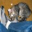

In [176]:
Image(filename=filename)

In [177]:
pred = deepwater_model.predict(random_test_image_hf)

deepwater prediction progress: |██████████████████████████████████████████████████████████████| 100%


In [178]:
predlabel = int(pred['predict'].as_data_frame(use_pandas=False)[1][0])

In [179]:
labels[predlabel]

'cat'